<h1>Classification using Naive Bayes models </h1>

In [1]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix
import seaborn as sns

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [2]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv')
data.shape

(109248, 9)

In [3]:
df = data.head(85000) #df is the dataset which we will use further in the assignment
df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
feature_set = df.drop(columns=['project_is_approved'])

In [5]:
target_set = df['project_is_approved']

In [6]:
print(feature_set.shape)
feature_set.head()

(85000, 8)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [7]:
print(target_set.shape)
target_set.head()

(85000,)


0    1
1    1
2    1
3    1
4    1
Name: project_is_approved, dtype: int64

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [8]:
x_train,x_test,y_train,y_test = train_test_split(feature_set,target_set,test_size=0.35,stratify= target_set, random_state= 69)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)    

(55250, 8)
(29750, 8)
(55250,)
(29750,)


<h2>1.3 Make Data Model Ready: encoding essay</h2>

In [10]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
cv = CountVectorizer(min_df=10)
cv.fit(x_train['essay'].values)

bow_train_essay = cv.transform(x_train['essay'].values)
bow_test_essay = cv.transform(x_test['essay'].values)

In [11]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
features_of_tfidf = []

tfidf = TfidfVectorizer()
tfidf.fit(x_train['essay'].values)

tfidf_train_essay = tfidf.transform(x_train['essay'].values)
tfidf_test_essay = tfidf.transform(x_test['essay'].values)

features_of_tfidf.extend(tfidf.get_feature_names())

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [12]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
""" school_state teacher_prefix project_grade_category clean_categories clean_subcategories """

one_hot = OneHotEncoder(handle_unknown="ignore")

one_hot.fit(x_train[['school_state']])

school_state_train_ohe = one_hot.transform(x_train[['school_state']])
school_state_test_ohe = one_hot.transform(x_test[['school_state']])

one_hot.fit(x_train[['teacher_prefix']])

teacher_prefix_train_ohe = one_hot.transform(x_train[['teacher_prefix']])
teacher_prefix_test_ohe = one_hot.transform(x_test[['teacher_prefix']])

one_hot.fit(x_train[['project_grade_category']])

project_grade_category_train_ohe = one_hot.transform(x_train[['project_grade_category']])
project_grade_category_test_ohe = one_hot.transform(x_test[['project_grade_category']])

one_hot.fit(x_train[['clean_categories']])

clean_categories_train_ohe = one_hot.transform(x_train[['clean_categories']])
clean_categories_test_ohe = one_hot.transform(x_test[['clean_categories']])

one_hot.fit(x_train[['clean_subcategories']])

clean_subcategories_train_ohe = one_hot.transform(x_train[['clean_subcategories']])
clean_subcategories_test_ohe = one_hot.transform(x_test[['clean_subcategories']])


In [13]:
# Apply Normalization on the numerical features using Normalizer().
""" teacher_number_of_previously_posted_projects price """

nv = Normalizer()

nv.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

teacher_number_of_previously_posted_projects_train_nv = nv.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
teacher_number_of_previously_posted_projects_test_nv = nv.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

nv.fit(x_train['price'].values.reshape(-1,1))

price_train_nv = nv.transform(x_train['price'].values.reshape(-1,1))
price_test_nv = nv.transform(x_test['price'].values.reshape(-1,1))

<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

In [14]:
# dataset with BOW vecotisation

bow_train_set  = hstack((school_state_train_ohe, teacher_prefix_train_ohe, project_grade_category_train_ohe, clean_categories_train_ohe, clean_subcategories_train_ohe, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, bow_train_essay)).tocsr()

bow_test_set = hstack((school_state_test_ohe, teacher_prefix_test_ohe, project_grade_category_test_ohe, clean_categories_test_ohe, clean_subcategories_test_ohe, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, bow_test_essay)).tocsr()

In [15]:
print(bow_train_set.shape)
print(bow_test_set.shape)

(55250, 13204)
(29750, 13204)


In [16]:
# Perform Hyperparameter Tuning
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

nb_bow_classifier = MultinomialNB(class_prior=[0.5, 0.5])

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}  

"""ignoring alpha values: 1000, 2000, 3000, 4000, 5000 as mean train and test socres for these alpha are 0.5 and for values of 100 and 500 the values were (0.50875706,0.5068243) and (0.49998931,0.49998931)"""

grid_search = GridSearchCV(nb_bow_classifier, parameters, cv= 10, scoring='roc_auc',return_train_score=True)
grid_search.fit(bow_train_set,y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]},
             return_train_score=True, scoring='roc_auc')

In [17]:
print("Train Scores: "+ str(grid_search.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_search.cv_results_['mean_test_score']))

Train Scores: [0.82005828 0.81905145 0.81848027 0.81673619 0.81576511 0.81283987
 0.81121335 0.80616962 0.80316061 0.79177454 0.78272937 0.73750857
 0.70585066 0.60537611]
CV Scores :[0.67868889 0.68214663 0.68379523 0.68797603 0.68989933 0.69445945
 0.69638842 0.70046016 0.70193153 0.70344612 0.70171498 0.68052693
 0.66158748 0.58919255]


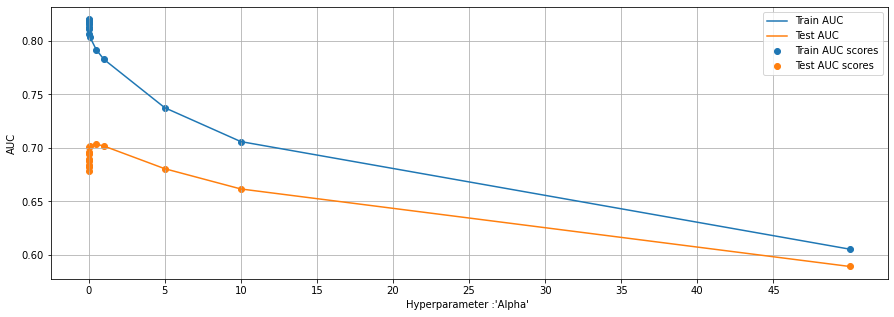

In [18]:
plt.figure(figsize=(15,5))
plt.plot(parameters['alpha'],grid_search.cv_results_['mean_train_score'], label = 'Train AUC')
plt.plot(parameters['alpha'], grid_search.cv_results_['mean_test_score'], label='Test AUC')
plt.scatter(parameters['alpha'], grid_search.cv_results_['mean_train_score'], label='Train AUC scores')
plt.scatter(parameters['alpha'], grid_search.cv_results_['mean_test_score'], label='Test AUC scores')

plt.legend()
plt.xlabel("Hyperparameter :'Alpha' ")
plt.ylabel("AUC")

plt.xticks(np.arange(0, 50, 5))

plt.grid()
plt.show()

In [19]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on 
print("BEST ALPHA: ",grid_search.best_params_['alpha']," BEST SCORE: ",grid_search.best_score_) 

BEST ALPHA:  0.5  BEST SCORE:  0.7034461177095419


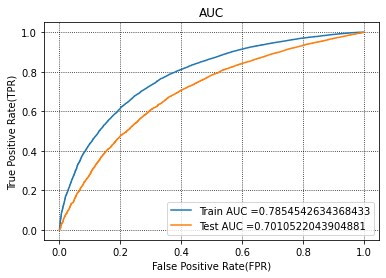

In [20]:

nb_bow = MultinomialNB(alpha=0.5)
nb_bow.fit(bow_train_set,y_train)

y_train_pred=nb_bow.predict_proba(bow_train_set)[:,1]
y_test_pred=nb_bow.predict_proba(bow_test_set)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()


In [21]:
r
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    return np.round(t,3)

def predict_with_thres(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [22]:
best_thres = find_best_threshold(tr_thresholds,train_fpr,train_tpr)
print("the maximum value of tpr*(1-fpr) is for threshold : ",best_thres)


the maximum value of tpr*(1-fpr) is for threshold :  0.872


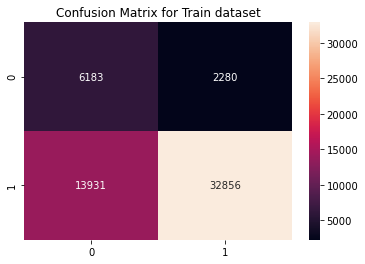

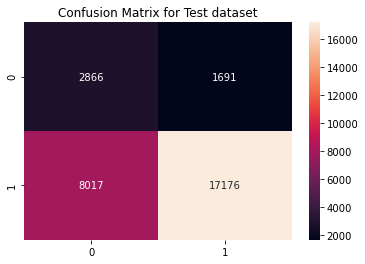

In [23]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

confusion_mat_train = confusion_matrix(y_train,predict_with_thres(y_train_pred,best_thres))
sns.heatmap(confusion_mat_train,annot=True,fmt = 'd')
plt.title("Confusion Matrix for Train dataset")
plt.show()

confusion_mat_test = confusion_matrix(y_test,predict_with_thres(y_test_pred,best_thres))
sns.heatmap(confusion_mat_test,annot=True,fmt = 'd')
plt.title("Confusion Matrix for Test dataset")
plt.show()


#### Set 2

In [24]:
# dataset with TF-IDF vecotisation

tfidf_train_set  = hstack((school_state_train_ohe, teacher_prefix_train_ohe, project_grade_category_train_ohe, clean_categories_train_ohe, clean_subcategories_train_ohe, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, tfidf_train_essay)).tocsr()

tfidf_test_set = hstack((school_state_test_ohe, teacher_prefix_test_ohe, project_grade_category_test_ohe, clean_categories_test_ohe, clean_subcategories_test_ohe, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, tfidf_test_essay)).tocsr()

In [25]:
print(tfidf_train_set.shape)
print(tfidf_test_set.shape)

(55250, 43521)
(29750, 43521)


In [26]:
# Perform Hyperparameter Tuning.
# Plotting the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot


nb_tfidf_classifier = MultinomialNB(class_prior=[0.5, 0.5])

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}  

"""ignoring alpha values: 100, 500, 1000, 2000, 3000, 4000, 5000 as mean train and test socres for these alpha are neglegibly impacted"""

grid_search = GridSearchCV(nb_tfidf_classifier, parameters, cv= 10, scoring='roc_auc',return_train_score=True)
grid_search.fit(tfidf_train_set,y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]},
             return_train_score=True, scoring='roc_auc')

In [27]:
print("Train Scores: "+ str(grid_search.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_search.cv_results_['mean_test_score']))

Train Scores: [0.92198348 0.91951108 0.91792788 0.91229453 0.90860131 0.89468173
 0.88482371 0.84366774 0.81444254 0.72641414 0.68761944 0.61445485
 0.59344602 0.56465224]
CV Scores :[0.60851045 0.61651544 0.6205452  0.63134069 0.63656364 0.64912731
 0.65387048 0.65789786 0.65486204 0.63516967 0.62207373 0.58871055
 0.57681698 0.55813441]


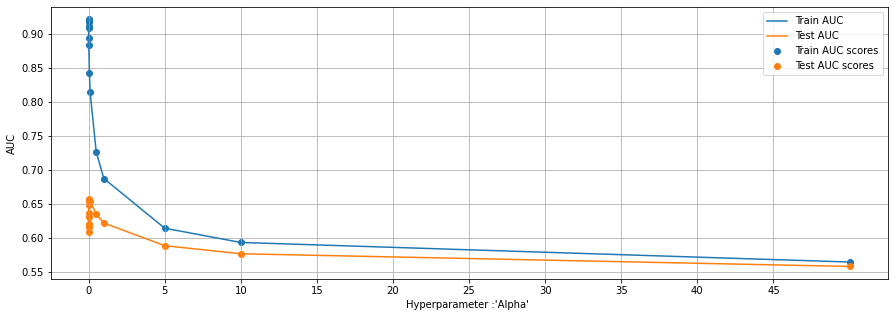

In [28]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
plt.figure(figsize=(15,5))
plt.plot(parameters['alpha'],grid_search.cv_results_['mean_train_score'], label = 'Train AUC')
plt.plot(parameters['alpha'], grid_search.cv_results_['mean_test_score'], label='Test AUC')
plt.scatter(parameters['alpha'], grid_search.cv_results_['mean_train_score'], label='Train AUC scores')
plt.scatter(parameters['alpha'], grid_search.cv_results_['mean_test_score'], label='Test AUC scores')

plt.legend()
plt.xlabel("Hyperparameter :'Alpha' ")
plt.ylabel("AUC")

plt.xticks(np.arange(0, 50, 5))

plt.grid()
plt.show()

In [29]:
print("BEST ALPHA: ",grid_search.best_params_['alpha']," BEST SCORE: ",grid_search.best_score_)

BEST ALPHA:  0.05  BEST SCORE:  0.6578978601051033


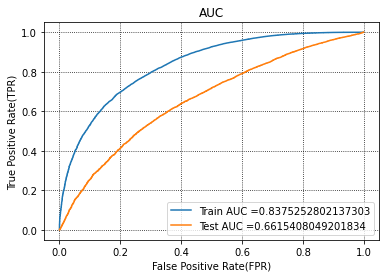

In [30]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

nb_tfidf = MultinomialNB(alpha=0.05)
nb_tfidf.fit(tfidf_train_set,y_train)

y_train_pred=nb_tfidf.predict_proba(tfidf_train_set)[:,1]
y_test_pred=nb_tfidf.predict_proba(tfidf_test_set)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()


In [31]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
best_thres = find_best_threshold(tr_thresholds,train_fpr,train_tpr)
print("the maximum value of tpr*(1-fpr) is for threshold : ",best_thres)


the maximum value of tpr*(1-fpr) is for threshold :  0.855


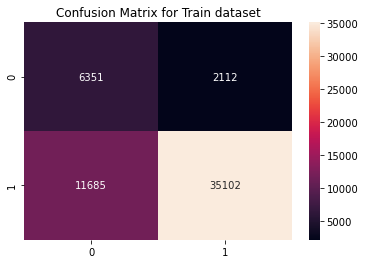

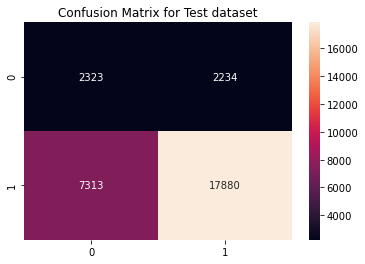

In [32]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

confusion_mat_train = confusion_matrix(y_train,predict_with_thres(y_train_pred,best_thres))
sns.heatmap(confusion_mat_train,annot=True,fmt = 'd')
plt.title("Confusion Matrix for Train dataset")
plt.show()

confusion_mat_test = confusion_matrix(y_test,predict_with_thres(y_test_pred,best_thres))
sns.heatmap(confusion_mat_test,annot=True,fmt = 'd')
plt.title("Confusion Matrix for Test dataset")
plt.show()


In [33]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. 
# (You have to print the names of the features, but not the indexes)

sorted_prob_pos = nb_tfidf.feature_log_prob_[1].argsort()
sorted_prob_neg = nb_tfidf.feature_log_prob_[0].argsort()


print('Top 20 features of positive class\n')
print(np.take(features_of_tfidf, sorted_prob_pos[-20:]))
print('=-='*30)
print('Top 20 features of negative class\n')
print(np.take(features_of_tfidf, sorted_prob_neg[-20:]))


Top 20 features of positive class

['01075rm' '1000s' '1017' '21t' '21sr' '1070' '10am' '11' 'suprisenannan'
 '120' '005nannan' '121' '1099' '11pm' '109' '108' '10cm' '1077' '28th'
 '29']
=-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-=
Top 20 features of negative class

['239' '01075rm' '21sr' '21t' '1017' '1070' '10am' '11' '120'
 'suprisenannan' '005nannan' '1099' '121' '11pm' '109' '108' '10cm' '1077'
 '28th' '29']


<h1>3. Summary</h1>

<br> 1. Taking very high values of alpha decreses the ACU scores for the model and be affects negligibly if alpha is increased further.
<br> 2. We have achieved High train scores for TF-IDF vecorised data set (AUC score = 0.8375),<br> but using BOW vectorisation we could see a better performing model for the Test data/prediction(AUC score= 0.7010)

In [36]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Alpha", "Train AUC", "Test AUC"]
table.add_row(["BoW", "Multinomial NB", 0.5, 0.7854,0.7010])
table.add_row(["TFIDF", "Multinomial NB", 0.005, 0.8375,0.6615])

print(table)

+------------+----------------+-------+-----------+----------+
| Vectorizer |     Model      | Alpha | Train AUC | Test AUC |
+------------+----------------+-------+-----------+----------+
|    BoW     | Multinomial NB |  0.5  |   0.7854  |  0.701   |
|   TFIDF    | Multinomial NB | 0.005 |   0.8375  |  0.6615  |
+------------+----------------+-------+-----------+----------+
